In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import Lasso

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pick=pd.read_csv('/content/drive/MyDrive/cleaned_pickup_data.csv')

In [4]:
pick.head()

,order_id,region_id,city,courier_id,accept_time,time_window_start,time_window_end,lng,lat,aoi_id,...,pickup_gps_lng,pickup_gps_lat,accept_gps_time,accept_gps_lng,accept_gps_lat,ds,time_window_duration,task_duration,distance,pi_gps_time
0,0.078492,0.022388,0,0.094485,1900-08-14 07:57:00,2000-01-01,2000-01-01,0.043854,0.036271,0.008882,...,0.633048,0.489546,1900-07-31 15:21:47.527556864,0.636678,0.438709,1970-01-01 00:00:00.000000814,0.0,6060.0,0.203825,1900-08-01 16:57:58.148008960
1,0.283371,0.022388,0,0.292917,1900-10-09 07:46:00,2000-01-01,2000-01-01,0.043852,0.036268,0.008882,...,0.633048,0.489546,1900-07-31 15:21:47.527556864,0.636678,0.438709,1970-01-01 00:00:00.000001009,0.0,6960.0,0.203825,1900-08-01 16:57:58.148008960
2,0.373535,0.022388,0,0.292917,1900-10-09 13:57:00,2000-01-01,2000-01-01,0.043851,0.036262,0.008882,...,0.157003,0.368339,1900-10-09 13:56:00.000000000,0.156368,0.298870,1970-01-01 00:00:00.000001009,0.0,6960.0,0.004725,1900-10-09 15:53:00.000000000
3,0.614853,0.022388,0,0.292917,1900-05-19 08:13:00,2000-01-01,2000-01-01,0.043854,0.036273,0.008882,...,0.633048,0.489546,1900-07-31 15:21:47.527556864,0.636678,0.438709,1970-01-01 00:00:00.000000519,0.0,13560.0,0.203825,1900-08-01 16:57:58.148008960
4,0.115780,0.022388,0,0.292917,1900-05-22 08:16:00,2000-01-01,2000-01-01,0.043828,0.036286,0.008882,...,0.157005,0.368533,1900-07-31 15:21:47.527556864,0.636678,0.438709,1970-01-01 00:00:00.000000522,0.0,8640.0,12.497969,1900-05-22 10:40:00.000000000


In [5]:
pick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202878 entries, 0 to 5202877
Data columns (total 23 columns):
 #   Column                Dtype  
---  ------                -----  
 0   order_id              float64
 1   region_id             float64
 2   city                  int64  
 3   courier_id            float64
 4   accept_time           object 
 5   time_window_start     object 
 6   time_window_end       object 
 7   lng                   float64
 8   lat                   float64
 9   aoi_id                float64
 10  aoi_type              int64  
 11  pickup_time           object 
 12  pickup_gps_time       object 
 13  pickup_gps_lng        float64
 14  pickup_gps_lat        float64
 15  accept_gps_time       object 
 16  accept_gps_lng        float64
 17  accept_gps_lat        float64
 18  ds                    object 
 19  time_window_duration  float64
 20  task_duration         float64
 21  distance              float64
 22  pi_gps_time           object 
dtypes: floa

In [6]:
time_columns = ['accept_time','time_window_start','time_window_end','pickup_time','pickup_gps_time','accept_gps_time','ds','pi_gps_time']

for col in time_columns:
    pick[col] = pd.to_datetime(pick[col],errors='coerce')

In [7]:
numerical_cols = pick.select_dtypes(include=np.number).columns

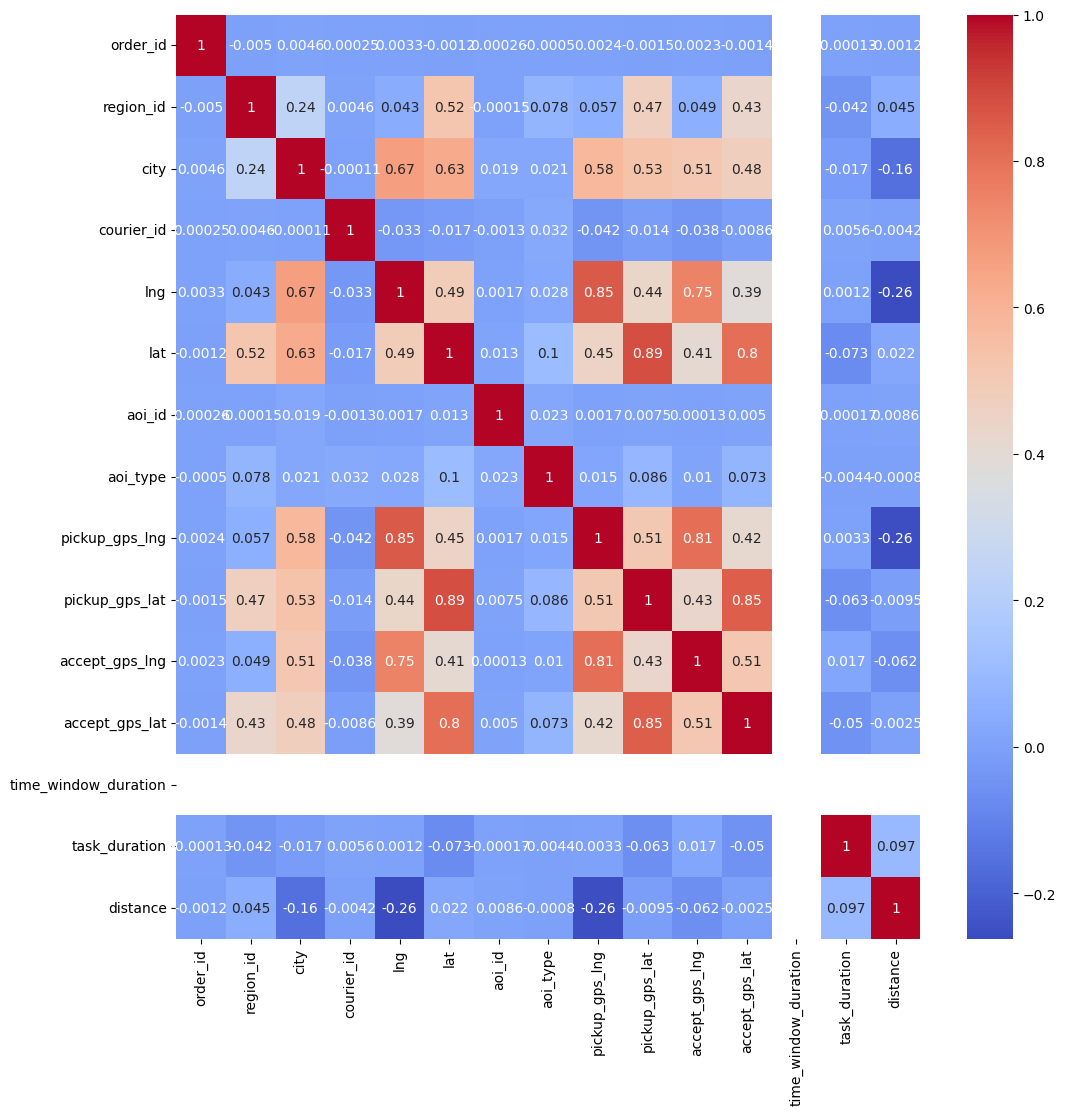

In [8]:
corr_matrix = pick[numerical_cols].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True,cmap='coolwarm')
plt.show()

In [10]:
pick['hour'] = pick['pickup_time'].dt.hour
pick['day'] = pick['pickup_time'].dt.day
pick['month'] = pick['pickup_time'].dt.month
pick['weekday'] = pick['pickup_time'].dt.weekday  # Monday=0, Sunday=6
pick['is_weekend'] = pick['weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [11]:
pick.columns

Index(['order_id', 'region_id', 'city', 'courier_id', 'accept_time',
       'time_window_start', 'time_window_end', 'lng', 'lat', 'aoi_id',
       'aoi_type', 'pickup_time', 'pickup_gps_time', 'pickup_gps_lng',
       'pickup_gps_lat', 'accept_gps_time', 'accept_gps_lng', 'accept_gps_lat',
       'ds', 'time_window_duration', 'task_duration', 'distance',
       'pi_gps_time', 'hour', 'day', 'month', 'weekday', 'is_weekend'],
      dtype='object')

In [12]:
pick['task_duration']=pick['task_duration']/60

In [14]:
## Dropping unnecessary features
pick.drop(['order_id','courier_id','time_window_start', 'time_window_end','aoi_id','pickup_gps_time','pickup_gps_lng','pickup_gps_lat','accept_gps_time',
           'accept_gps_lng','accept_gps_lat','ds','time_window_duration','pi_gps_time',], axis=1, inplace=True)

In [15]:
pick.head()

,region_id,city,accept_time,lng,lat,aoi_type,pickup_time,task_duration,distance,hour,day,month,weekday,is_weekend
0,0.022388,0,1900-08-14 07:57:00,0.043854,0.036271,14,1900-08-14 09:38:00,101.0,0.203825,9,14,8,1,0
1,0.022388,0,1900-10-09 07:46:00,0.043852,0.036268,14,1900-10-09 09:42:00,116.0,0.203825,9,9,10,1,0
2,0.022388,0,1900-10-09 13:57:00,0.043851,0.036262,14,1900-10-09 15:53:00,116.0,0.004725,15,9,10,1,0
3,0.022388,0,1900-05-19 08:13:00,0.043854,0.036273,14,1900-05-19 11:59:00,226.0,0.203825,11,19,5,5,1
4,0.022388,0,1900-05-22 08:16:00,0.043828,0.036286,14,1900-05-22 10:40:00,144.0,12.497969,10,22,5,1,0


In [18]:
pick.to_csv('pickup_featured_data.csv', index=False)